# **Flight Airport Networks in Indonesia**
### DATA 620 - Project 1
#### Claudio, Mauricio
#### 18 February 2024
___
___

## 1. Identify and load a network dataset that has some categorical information available for each node.
___

![](openflights.png)

The [OpenFlights Airports Database](https://openflights.org/data.php) contains over 10,000 airports, train stations and ferry terminals spanning the globe, as shown in the map above. In this project, we make use of its [Airports](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat) and flight [Routes](https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat) datasets to visualize and determine which airports for the country of Indonesia, my country of residence, as act as air hubs. To do so, we estimate the Degree Centrality and Eigen Centrality for each airport, and on the basis of those two measures we determine which airports are the major air hubs in the country.

In [40]:
### Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats as stt

# Magical matplotlib command
%matplotlib inline

In [41]:
### Load and display routes data info
dat_routes = pd.read_csv("routes.csv")                         
dat_routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67663 entries, 0 to 67662
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   OriginAirport       67663 non-null  object
 1   DestinationAirport  67663 non-null  object
 2   Stops               67663 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [49]:
### Route data sample, the tail
dat_routes.tail(10)

,OriginAirport,DestinationAirport,Stops
67653,TSV,WIN,0
67654,WGA,MEL,0
67655,WGA,SYD,0
67656,WIN,LRE,0
67657,WIN,TSV,0
67658,WYA,ADL,0
67659,DME,FRU,0
67660,FRU,DME,0
67661,FRU,OSS,0
67662,OSS,FRU,0


In [50]:
### Load airport data info
dat_airports = pd.read_csv("airports.csv")

### Subset Republik Indonesia (RI) airports
airports_RI = dat_airports.loc[dat_airports['Country'] == 'Indonesia']

airports_RI.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 3055 to 7684
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Airport    145 non-null    object 
 1   City       145 non-null    object 
 2   Country    145 non-null    object 
 3   IATA       145 non-null    object 
 4   ICAO       145 non-null    object 
 5   Latitude   145 non-null    float64
 6   Longitude  145 non-null    float64
dtypes: float64(2), object(5)
memory usage: 9.1+ KB


In [51]:
### Airport data sample, the headtail
airports_RI.head(10)

,Airport,City,Country,IATA,ICAO,Latitude,Longitude
3055,Hasanuddin International Airport,Ujung Pandang,Indonesia,UPG,WAAA,-5.061630,119.554001
3056,Frans Kaisiepo Airport,Biak,Indonesia,BIK,WABB,-1.190020,136.108002
3057,Nabire Airport,Nabire,Indonesia,NBX,WABI,-3.368180,135.496002
3058,Moses Kilangin Airport,Timika,Indonesia,TIM,WABP,-4.528280,136.886993
3059,Sentani International Airport,Jayapura,Indonesia,DJJ,WAJJ,-2.576950,140.516007
3060,Wamena Airport,Wamena,Indonesia,WMX,WAJW,-4.102510,138.957001
3061,Mopah Airport,Merauke,Indonesia,MKQ,WAKK,-8.520290,140.417999
3062,Jalaluddin Airport,Gorontalo,Indonesia,GTO,WAMG,0.637119,122.849998
3063,Mutiara Airport,Palu,Indonesia,PLW,WAML,-0.918542,119.910004
3064,Sam Ratulangi Airport,Manado,Indonesia,MDC,WAMM,1.549260,124.926003


In [52]:
### Make airport node list
nodes = pd.DataFrame(set(dat_routes['OriginAirport']) | set(dat_routes['DestinationAirport']),
                     columns = ['IATA'])
#nodes.head()

In [53]:
### Merge nodes with airports
nodes_airports = pd.merge(nodes, airports_RI,
                          on='IATA',
                          how='inner')
#nodes_airports.info()

In [54]:
nodes_airports.head(10)

,IATA,Airport,City,Country,ICAO,Latitude,Longitude
0,KOE,El Tari Airport,Kupang,Indonesia,WATT,-10.171600,123.670998
1,BPN,Sultan Aji Muhamad Sulaiman Airport,Balikpapan,Indonesia,WALL,-1.268270,116.893997
2,DOB,Rar Gwamar Airport,Dobo,Indonesia,WAPD,-5.772220,134.212006
3,MDC,Sam Ratulangi Airport,Manado,Indonesia,WAMM,1.549260,124.926003
4,BMU,Muhammad Salahuddin Airport,Bima,Indonesia,WADB,-8.539650,118.686997
5,PDG,Minangkabau International Airport,Padang,Indonesia,WIPT,-0.786917,100.280998
6,TKG,Radin Inten II (Branti) Airport,Bandar Lampung-Sumatra Island,Indonesia,WIAT,-5.240556,105.175556
7,TNJ,Raja Haji Fisabilillah International Airport,Tanjung Pinang,Indonesia,WIDN,0.922683,104.531998
8,SXK,Saumlaki/Olilit Airport,Saumlaki,Indonesia,WAPI,-7.988610,131.306000
9,NTX,Ranai Airport,Ranai-Natuna Besar Island,Indonesia,WION,3.908710,108.388000


In [55]:
### Merge routes and airports

# First, merge routes and airports on OriginAirport
routes_merge1 = pd.merge(dat_routes, nodes_airports[['IATA']],
                          left_on='OriginAirport',
                          right_on='IATA',
                          how='inner')

# Second, merge earlier merge dataset with DestinationAirports
routes_merge2 = pd.merge(routes_merge1, nodes_airports[['IATA']],
                          left_on='DestinationAirport',
                          right_on='IATA',
                          how='inner')

# Third, subset variable of interest
routes = routes_merge2.loc[:, 'OriginAirport':'Stops']
routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   OriginAirport       611 non-null    object
 1   DestinationAirport  611 non-null    object
 2   Stops               611 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 14.4+ KB


<br>  

## 2. For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
___

Each node is one of the 145 Indonesian airports in the dataset. We calculate airport Degree Centrality and Eigenvector centrality. But before we do that we graph the relationship among all airports to get a general glimpse into which airports act generally as hubs.  

From the graph, four (4) nodes stand out as air hubs judging from the higher number of arrows pointing to them. These airports are:  
* the country capital Jakarta's *Sukarno-Hatta* (**CGK**),
* the resort holiday destination of Bali's *Ngurah Rai* (**DPS**), and
* the Celebes island city of Makassar's *Sultan Hasanuddin* (**UPG**)

![](IndonesiaMap.jpg)

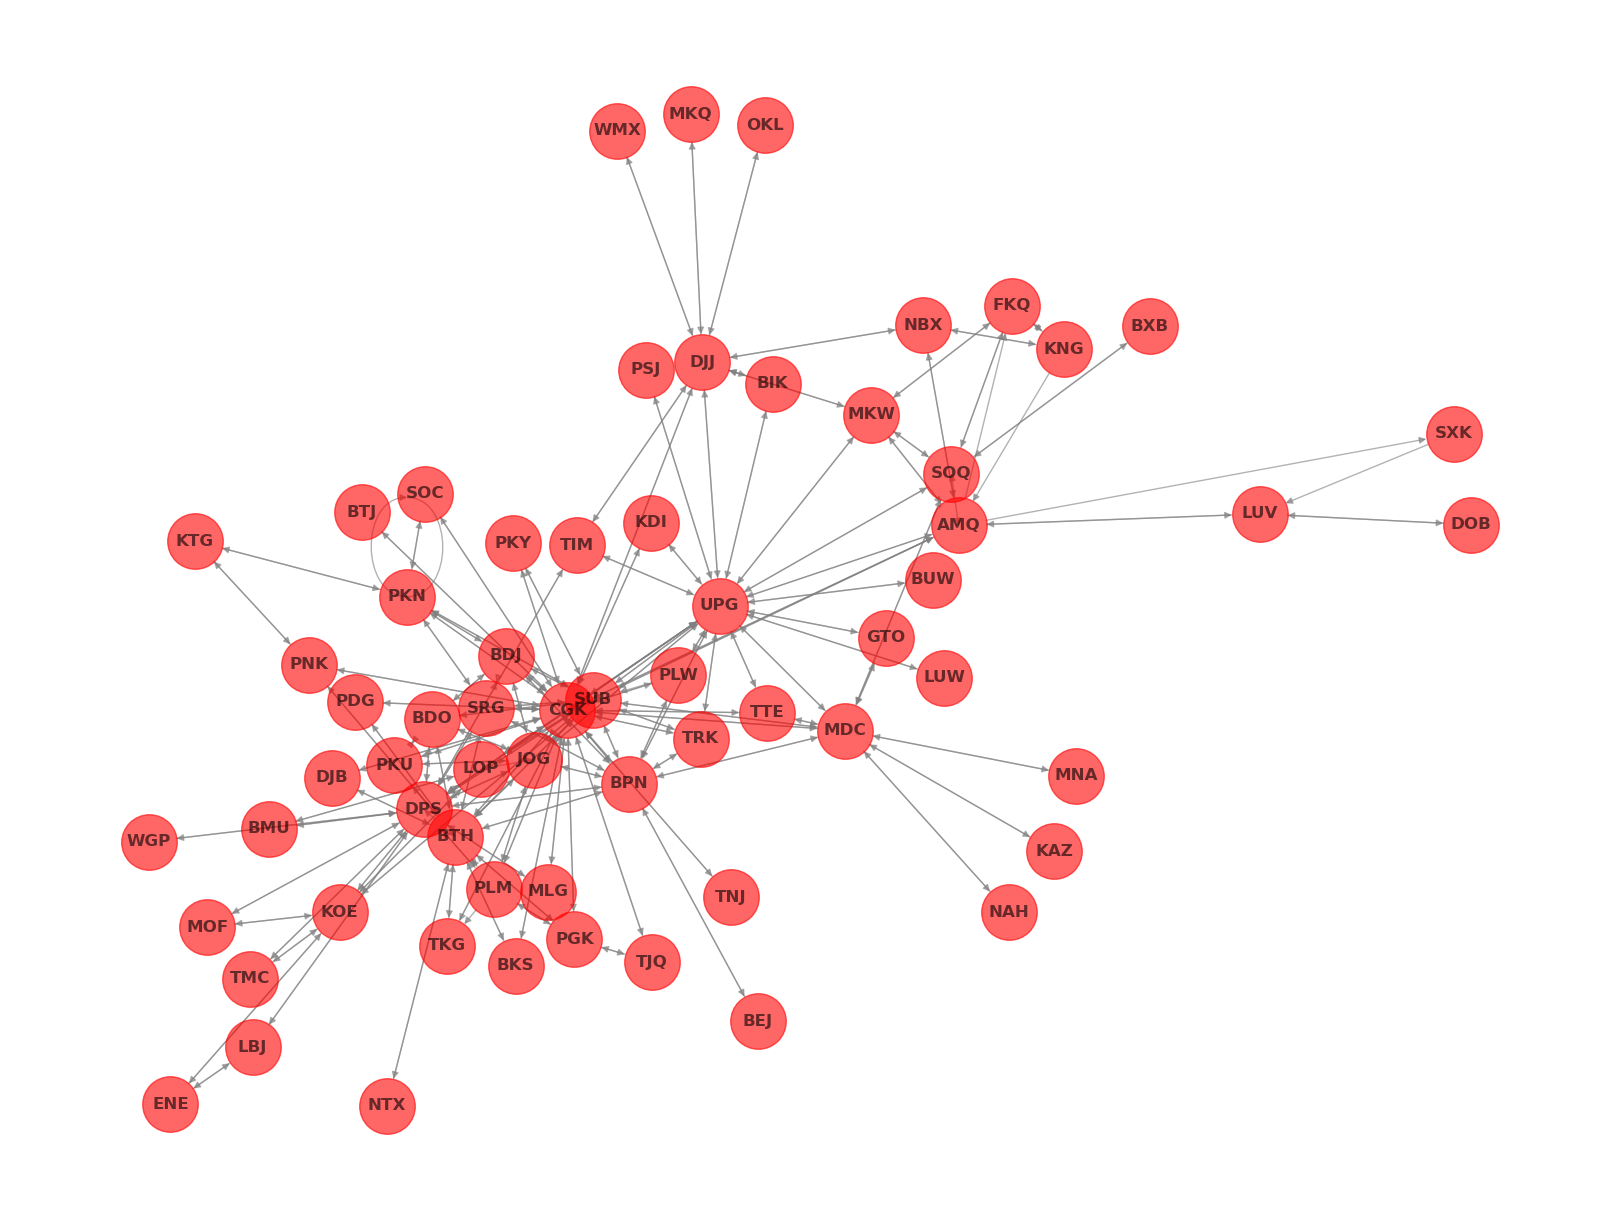

In [78]:
### Instantiate and define graph inputs and parameters
graph = nx.from_pandas_edgelist(routes,
                                'OriginAirport',
                                'DestinationAirport',
                                True,
                                nx.DiGraph())

nx.set_node_attributes(graph,
                       nodes_airports.set_index('IATA').to_dict('index'))

### Draw the Graph
plt.rcParams["figure.figsize"] = (16, 12) # set plot size
nx.draw(graph,
        node_size=1600,
        node_color='red',
        edge_color='grey',
        font_weight='bold',
        with_labels=True,
        font_size=12,
        alpha=0.6)

___

### Degree Centrality
The degree centrality of a node is simply its degree, that is, the number of edges or lines it has. The greater the degree, the more central a node is. Usually, nodes with high degree centrality also have high centrality by other measures.

The Top-5 Indonesian airports by Degree Centrality are as follows:
1. Jakarta's *Soekarno-Hatta* (**CGK**): 62
2. Makassar's ('Ujung Pandang') *Hasanuddin* (**UPG**): 42
3. Bali's *Ngurah Rai* (**DPS**): 36
4. Surabaya's *Juanda* (**SUB**): 33
5. Batam's *Hang Nadim* (**BTH**): 32

In [69]:
### Calculate degree centrality
deg_central = nx.degree(graph)

deg_dat = pd.DataFrame(deg_central,
                      columns = ['IATA', 'Deg_Centrality'])

deg_dat = pd.merge(deg_dat, airports_RI,
                  on='IATA',
                  how='inner')

sorted_deg = deg_dat.sort_values('Deg_Centrality',
                                ascending = False)
sorted_deg.head(10)

,IATA,Deg_Centrality,Airport,City,Country,ICAO,Latitude,Longitude
0,CGK,62,Soekarno-Hatta International Airport,Jakarta,Indonesia,WIII,-6.12557,106.655998
3,UPG,42,Hasanuddin International Airport,Ujung Pandang,Indonesia,WAAA,-5.06163,119.554001
17,DPS,36,Ngurah Rai (Bali) International Airport,Denpasar,Indonesia,WADD,-8.74817,115.167000
2,SUB,33,Juanda International Airport,Surabaya,Indonesia,WARR,-7.37983,112.787003
16,BTH,32,Hang Nadim International Airport,Batam,Indonesia,WIDD,1.12103,104.119003
11,BPN,24,Sultan Aji Muhamad Sulaiman Airport,Balikpapan,Indonesia,WALL,-1.26827,116.893997
12,JOG,22,Adi Sutjipto International Airport,Yogyakarta,Indonesia,WARJ,-7.78818,110.431999
19,MDC,20,Sam Ratulangi Airport,Manado,Indonesia,WAMM,1.54926,124.926003
31,DJJ,18,Sentani International Airport,Jayapura,Indonesia,WAJJ,-2.57695,140.516007
1,AMQ,17,"Pattimura Airport, Ambon",Ambon,Indonesia,WAPP,-3.71026,128.089004


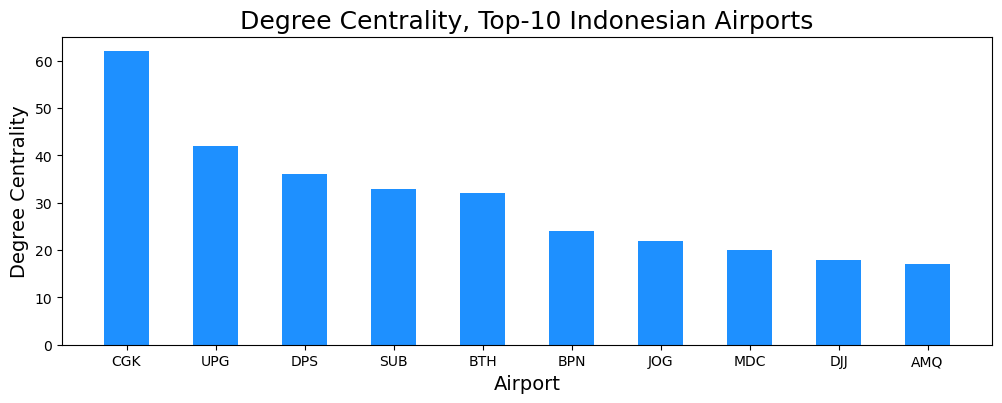

In [71]:
### Plot Top-10 Degree Centrality vs City,
top10 = sorted_deg.head(10)

plt.figure(figsize=(12,4))
plt.bar(np.array(top10['IATA']),
        np.array(top10['Deg_Centrality']),
        color ='dodgerblue', 
        width = 0.5)

plt.xlabel("Airport", fontsize=14)
plt.ylabel("Degree Centrality", fontsize=14)
plt.title("Degree Centrality, Top-10 Indonesian Airports", fontsize=18)
plt.show()

___

### Eigenvector Centrality
Eigenvector centrality is a measure of the influence or prestige of a node in a network. Unlike Degree Centrality where connections are not weighted by node influence or score, in Eigenvector Centrality connections to high-scoring nodes contribute more than connections to low-scoring nodes. Therefore, a high eigenvector score means that a node is connected to nodes that themselves have high scores.
  
The Top-5 Indonesian airports by Eigenvector Centrality are as follows:  
  
1. 
Jakarta'*s Soekarno-Hat* (**CGK**)K)0.418130  
2. Surabaya's *Juanda* (**SUB**): 0.329430  
3. Bali's *Ngurah Rai* (**DPS**): 0.289594  
4. Makassar's ('Ujung Pandang') *Hasanuddin* (**UPG**): 0.287903  
5. Balikpapan *Sultan Aji Muhamad Sulaiman* (**BPN**): 0.264499: 32



In [88]:
### Calculate Eigen centrality
eigen_central = nx.eigenvector_centrality(graph)
eig_dat = pd.DataFrame.from_dict(eigen_central,
                                 orient='index').reset_index()

eig_dat.columns = ['IATA', 'Eig_Centrality']

eig_dat = pd.merge(eig_dat, airports_RI,
                   on='IATA',
                   how='inner')

sorted_eig = eig_dat.sort_values('Eig_Centrality',
                                 ascending = False)
sorted_eig.head(10)

,IATA,Eig_Centrality,Airport,City,Country,ICAO,Latitude,Longitude
0,CGK,0.418130,Soekarno-Hatta International Airport,Jakarta,Indonesia,WIII,-6.125570,106.655998
2,SUB,0.329430,Juanda International Airport,Surabaya,Indonesia,WARR,-7.379830,112.787003
17,DPS,0.289594,Ngurah Rai (Bali) International Airport,Denpasar,Indonesia,WADD,-8.748170,115.167000
3,UPG,0.287903,Hasanuddin International Airport,Ujung Pandang,Indonesia,WAAA,-5.061630,119.554001
11,BPN,0.264499,Sultan Aji Muhamad Sulaiman Airport,Balikpapan,Indonesia,WALL,-1.268270,116.893997
16,BTH,0.263067,Hang Nadim International Airport,Batam,Indonesia,WIDD,1.121030,104.119003
12,JOG,0.260814,Adi Sutjipto International Airport,Yogyakarta,Indonesia,WARJ,-7.788180,110.431999
13,SRG,0.188794,Achmad Yani Airport,Semarang,Indonesia,WARS,-6.972730,110.375000
9,BDJ,0.175246,Syamsudin Noor Airport,Banjarmasin,Indonesia,WAOO,-3.442360,114.763000
37,LOP,0.173497,Lombok International Airport,Praya,Indonesia,WADL,-8.757322,116.276675


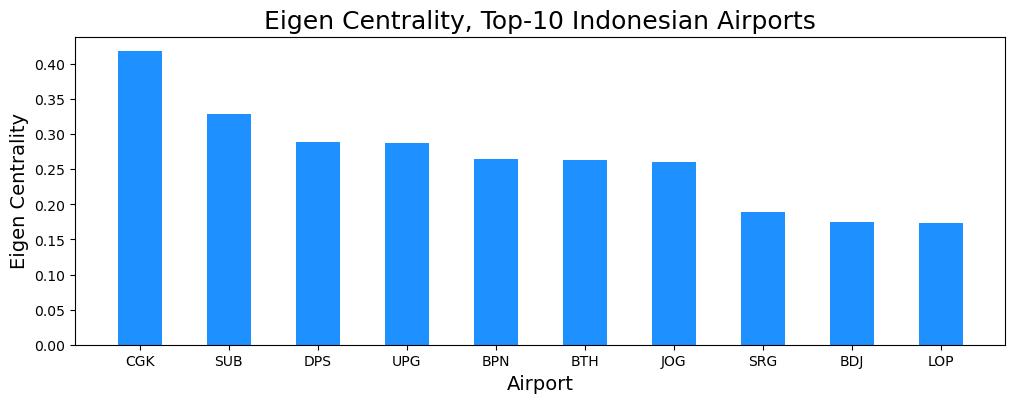

In [89]:
### Plot Top-10 Eigenvector Centrality vs City,
top10 = sorted_eig.head(10)

plt.figure(figsize=(12,4))

plt.bar(np.array(top10['IATA']),
        np.array(top10['Eig_Centrality']),
        color ='dodgerblue',
        #alpha = 0.6,
        width = 0.5)

plt.xlabel("Airport", fontsize=14)
plt.ylabel("Eigen Centrality", fontsize=14)
plt.title("Eigen Centrality, Top-10 Indonesian Airports", fontsize=18)
plt.show()

<br>
  
## 3. Compare your centrality measures across your categorical groups.
___

In terms of Degree centrality, there is little that is surprising in the Top-5 ranking of airports. The country's capital Jakarta is number one, and Bali, the premier tourist destination receiving some five million visitors each year is number three. On the surface, Makassar ("Ujung Pandang"), the country's fifth largest city, coming in at number two is a bit surprising. Nevertheless, when taking into account that Makassar is the main transit hub for the rest of Celebes island, the Malucca islands and Indonesian Papua, the result makes sense as Makassar drops to number four in terms of Eigenvector centrality, a reflection that most of its connections are relatively minor places with few connections themselves.

Batam, situated in the Straits of Malacca offshore from Singapore, is similar to Makassar in ranking high, number five, in Degree centrality, but much lower, off the Top-5, in Eigenvector centrality. Again, Batam's high Degree Centrality but low Eigenvector centrality is due to its very many connections to relatively unimportant, unconnected places.

Surabaya is the country's fourth largest city and second largest after Jakarta on the main island of Java. It places fourth in Degree centrality, but rises to number two in Eigenvector centrality. This makes sense as, though it may not have the number of connections as Makassar, the connections that it does have are to places like Jakarta and Bali, themselves high on both Degree and Eigenvector centrality.

Finally, the city of Balikpapan on the east coast of Kalimantan (i.e. Indonesian Borneo) does not rank high in Degree centrality as expected, but perhaps due to its importance a gateway to oil field installations comes in at number five in Eigenvector centrality as it is likely well connected to the capital city of Jakarta.  
  
A video presentation of this project is available [here](https://youtu.be/7U6V__RZgi8).

___
___